In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib. pyplot as plt
import matplotlib
from sklearn. preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
import numpy as np


In [6]:
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model

import matplotlib.dates as mdates

# If you need to use a Keras backend function
from tensorflow.keras import backend as K

In [179]:
# Load the parquet data
df = pd.read_parquet('train_data.parquet')

# Display the loaded data
df.head()

,brand,phase,country,dayweek,month,wd_perc,ther_area,hospital_rate,n_nwd_bef,n_nwd_aft,n_weekday_0,n_weekday_1,n_weekday_2,n_weekday_3,n_weekday_4,date,wd,wd_left,monthly,main_channel
0,AIMST,0.006284,Aldovia,2.0,1.0,0.045455,NaN,NaN,4.0,0.0,4,4,5,5,4,2013-01-02,1,21,0.008092,NaN
1,AIMST,0.123459,Aldovia,3.0,1.0,0.090909,NaN,NaN,0.0,0.0,4,4,5,5,4,2013-01-03,2,20,0.008092,NaN
2,AIMST,0.055607,Aldovia,4.0,1.0,0.136364,NaN,NaN,0.0,2.0,4,4,5,5,4,2013-01-04,3,19,0.008092,NaN
3,AIMST,0.032148,Aldovia,0.0,1.0,0.181818,NaN,NaN,2.0,0.0,4,4,5,5,4,2013-01-07,4,18,0.008092,NaN
4,AIMST,0.097054,Aldovia,1.0,1.0,0.227273,NaN,NaN,0.0,0.0,4,4,5,5,4,2013-01-08,5,17,0.008092,NaN


In [180]:
df.set_index('date', inplace=True)

In [181]:
df_themy = df[(df['country']=='Themyscira') & (df['brand']=='EUJWP')]

In [182]:
#Print the shape of Dataframe  and Check for Null Values
print("Dataframe Shape: ", df_themy. shape)
print("Null Value Present: ", df_themy.isnull(). values. any())

Dataframe Shape:  (1249, 19)
Null Value Present:  False


<Axes: xlabel='date'>

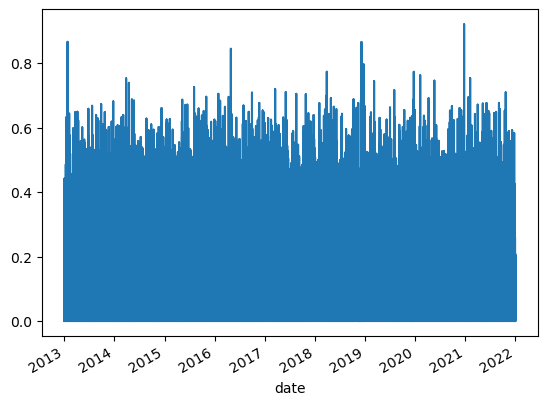

In [183]:
#Plot the True Adj Close Value
df["phase"].plot()

In [184]:
df_themy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1249 entries, 2013-01-02 to 2018-02-27
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   brand          1249 non-null   object  
 1   phase          1249 non-null   float64 
 2   country        1249 non-null   object  
 3   dayweek        1249 non-null   float64 
 4   month          1249 non-null   float64 
 5   wd_perc        1249 non-null   float64 
 6   ther_area      1249 non-null   category
 7   hospital_rate  1249 non-null   float64 
 8   n_nwd_bef      1249 non-null   float64 
 9   n_nwd_aft      1249 non-null   float64 
 10  n_weekday_0    1249 non-null   int64   
 11  n_weekday_1    1249 non-null   int64   
 12  n_weekday_2    1249 non-null   int64   
 13  n_weekday_3    1249 non-null   int64   
 14  n_weekday_4    1249 non-null   int64   
 15  wd             1249 non-null   int64   
 16  wd_left        1249 non-null   int64   
 17  monthly        

In [185]:
#Set Target Variable
output_var = pd.DataFrame(df_themy["phase"])
#Selecting the Features
features = ['dayweek', 'month', 'wd_perc', 'n_nwd_bef', 'n_nwd_aft', 'wd', 'wd_left', 'monthly']

In [186]:
df_themy[features].head()

,dayweek,month,wd_perc,n_nwd_bef,n_nwd_aft,wd,wd_left,monthly
date,,,,,,,,
2013-01-02,2.0,1.0,0.045455,11.0,0.0,1,21,0.064667
2013-01-03,3.0,1.0,0.090909,0.0,0.0,2,20,0.064667
2013-01-04,4.0,1.0,0.136364,0.0,2.0,3,19,0.064667
2013-01-07,0.0,1.0,0.181818,2.0,0.0,4,18,0.064667
2013-01-08,1.0,1.0,0.227273,0.0,0.0,5,17,0.064667


In [187]:
#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df_themy[features])


In [188]:
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df_themy.index)
feature_transform.head()

,dayweek,month,wd_perc,n_nwd_bef,n_nwd_aft,wd,wd_left,monthly
date,,,,,,,,
2013-01-02,0.333333,0.0,0.003953,1.000000,0.000000,0.000000,0.913043,0.647925
2013-01-03,0.500000,0.0,0.051383,0.000000,0.000000,0.043478,0.869565,0.647925
2013-01-04,0.666667,0.0,0.098814,0.000000,0.222222,0.086957,0.826087,0.647925
2013-01-07,0.000000,0.0,0.146245,0.181818,0.000000,0.130435,0.782609,0.647925
2013-01-08,0.166667,0.0,0.193676,0.000000,0.000000,0.173913,0.739130,0.647925


In [85]:
datetime_indices = feature_transform.index  # Get the datetime indices from the DataFrame
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()  

        # Extract datetime indices for the test set
        test_datetime_indices = datetime_indices[test_index]     

Instead of using scikitlearn inherent timesplit

In [189]:
# Assuming 'datetime_indices' are your DataFrame's datetime indices
datetime_indices = pd.to_datetime(feature_transform.index)

# Get unique months
unique_months = datetime_indices.to_period('M').unique()
unique_months

PeriodIndex(['2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06',
             '2013-07', '2013-08', '2013-09', '2013-10', '2013-11', '2013-12',
             '2014-01', '2014-02', '2014-03', '2014-05', '2014-06', '2014-07',
             '2014-08', '2014-09', '2014-10', '2014-11', '2014-12', '2015-02',
             '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08',
             '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02',
             '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08',
             '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02',
             '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08',
             '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02'],
            dtype='period[M]', name='date')

In [190]:
type(datetime_indices)

pandas.core.indexes.datetimes.DatetimeIndex

In [191]:
for i in range(1, len(unique_months)):
    train_months = unique_months[:i]
    test_months = unique_months[i:i+1]

    train_mask = datetime_indices.to_period('M').isin(train_months)
    test_mask = datetime_indices.to_period('M').isin(test_months)

    X_train, X_test = feature_transform[train_mask], feature_transform[test_mask]
    y_train, y_test = output_var[train_mask].values.ravel(), output_var[test_mask].values.ravel()
    
    # Extract datetime indices for the test set
    test_datetime_indices = datetime_indices[test_mask]  

In [192]:
#Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [193]:
test_datetime_indices

DatetimeIndex(['2018-02-01', '2018-02-02', '2018-02-05', '2018-02-06',
               '2018-02-07', '2018-02-08', '2018-02-09', '2018-02-12',
               '2018-02-13', '2018-02-14', '2018-02-15', '2018-02-16',
               '2018-02-19', '2018-02-20', '2018-02-21', '2018-02-22',
               '2018-02-23', '2018-02-26', '2018-02-27'],
              dtype='datetime64[us]', name='date', freq=None)

In [194]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation="relu", return_sequences=False))
lstm.add(Dense(1, activation='relu'))
lstm.compile(loss="mean_squared_error", optimizer="adam")
plot_model(lstm, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Epoch 1/100
154/154 [==============================] - 3s 17ms/step - loss: 0.0025
Epoch 2/100
154/154 [==============================] - 2s 16ms/step - loss: 0.0024
Epoch 3/100
154/154 [==============================] - 2s 16ms/step - loss: 0.0023
Epoch 4/100
154/154 [==============================] - 2s 15ms/step - loss: 0.0023
Epoch 5/100
154/154 [==============================] - 2s 15ms/step - loss: 0.0023
Epoch 6/100
154/154 [==============================] - 2s 15ms/step - loss: 0.0022
Epoch 7/100
154/154 [==============================] - 2s 16ms/step - loss: 0.0022
Epoch 8/100
154/154 [==============================] - 2s 16ms/step - loss: 0.0022
Epoch 9/100
154/154 [==============================] - 2s 16ms/step - loss: 0.0022
Epoch 10/100
154/154 [==============================] - 3s 16ms/step - loss: 0.0022
Epoch 11/100
154/154 [==============================] - 2s 15ms/step - loss: 0.0022
Epoch 12/100
154/154 [==============================] - 2s 15ms/step - loss: 0.0022
E

KeyError: 'val_loss'

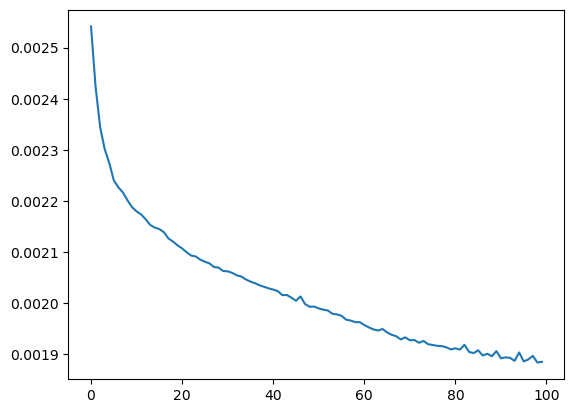

In [195]:
#Model Training
history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [144]:
#LSTM Prediction
y_pred= lstm.predict(X_test)

1/1 [==============================] - 0s 204ms/step


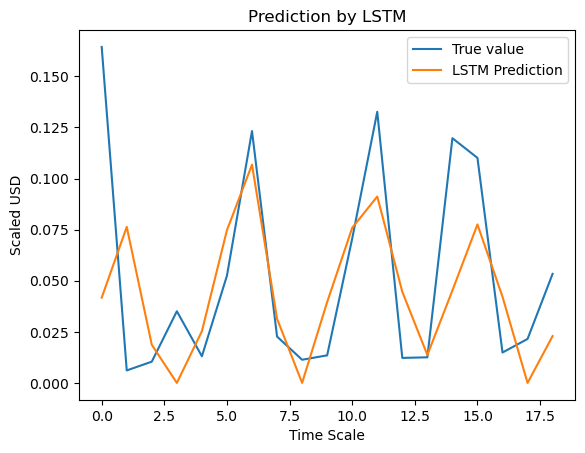

In [145]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label="True value")
plt.plot(y_pred, label="LSTM Prediction")
plt.title("Prediction by LSTM")
plt.xlabel("Time Scale")
plt.ylabel("Scaled USD")
plt.legend()
plt.show()

In [146]:
y_pred = y_pred.reshape(y_pred.shape[0], 1)
y_pred

array([[0.04170553],
       [0.07633125],
       [0.0186571 ],
       [0.        ],
       [0.02529963],
       [0.07475573],
       [0.10678965],
       [0.03138781],
       [0.        ],
       [0.03956536],
       [0.07590339],
       [0.091207  ],
       [0.04460448],
       [0.01368261],
       [0.0452591 ],
       [0.0775487 ],
       [0.04213403],
       [0.        ],
       [0.02292269]], dtype=float32)

In [147]:
y_test

array([0.16441618, 0.00610905, 0.01041048, 0.03507869, 0.01304093,
       0.05247445, 0.12323872, 0.02268644, 0.01133357, 0.01349216,
       0.07062954, 0.13268266, 0.01223738, 0.01253123, 0.11975226,
       0.11011889, 0.01487395, 0.02152644, 0.05336696])

In [160]:
test_datetime_indices

DatetimeIndex(['2017-09-12', '2017-09-13', '2017-09-14', '2017-09-15',
               '2017-09-18', '2017-09-19', '2017-09-20', '2017-09-21',
               '2017-09-22', '2017-09-25',
               ...
               '2018-02-14', '2018-02-15', '2018-02-16', '2018-02-19',
               '2018-02-20', '2018-02-21', '2018-02-22', '2018-02-23',
               '2018-02-26', '2018-02-27'],
              dtype='datetime64[us]', name='date', length=113, freq=None)

In [163]:
# Create a DataFrame for the predictions with datetime indices
#predictions_df = pd.DataFrame(y_pred, index=test_datetime_indices, columns=['Predictions'])
predictions_df = pd.DataFrame(y_pred, index=test_datetime_indices, columns=['Predictions'])
predictions_df.head()


,Predictions
date,
2018-02-01,0.041706
2018-02-02,0.076331
2018-02-05,0.018657
2018-02-06,0.000000
2018-02-07,0.025300


In [164]:
predictions_df

,Predictions
date,
2018-02-01,0.041706
2018-02-02,0.076331
2018-02-05,0.018657
2018-02-06,0.000000
2018-02-07,0.025300
2018-02-08,0.074756
2018-02-09,0.106790
2018-02-12,0.031388
2018-02-13,0.000000


<Axes: xlabel='date'>

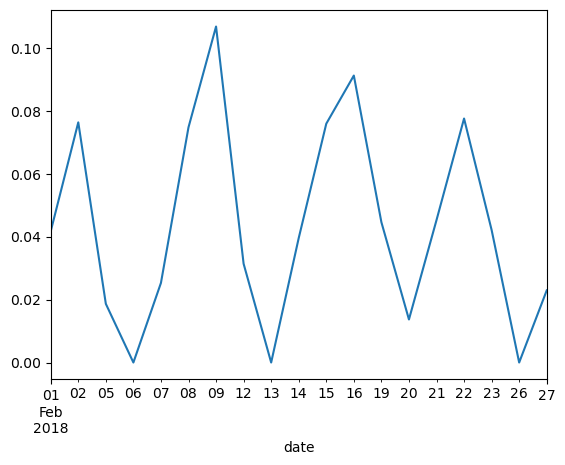

In [165]:
predictions_df['Predictions'].plot()

In [166]:
# Group by month and sum the predictions
monthly_sum = predictions_df.resample('M').sum()

# Check if the sum is approximately 1 for each month
# Note: Depending on your data, you might want to allow for a small margin of error
is_one_per_month = monthly_sum['Predictions'].apply(lambda x: abs(x - 1) < 0.01)

# Print the result
print(is_one_per_month)

date
2018-02-28    False
Freq: M, Name: Predictions, dtype: bool


In [167]:
monthly_sum

,Predictions
date,
2018-02-28,0.827754


In [168]:
y_pred

array([[0.04170553],
       [0.07633125],
       [0.0186571 ],
       [0.        ],
       [0.02529963],
       [0.07475573],
       [0.10678965],
       [0.03138781],
       [0.        ],
       [0.03956536],
       [0.07590339],
       [0.091207  ],
       [0.04460448],
       [0.01368261],
       [0.0452591 ],
       [0.0775487 ],
       [0.04213403],
       [0.        ],
       [0.02292269]], dtype=float32)

In [169]:
import numpy as np
import pandas as pd

# Assuming y_pred are your predictions and you have a corresponding date array
#dates = pd.to_datetime()  # Dates corresponding to y_pred
#predictions = pd.DataFrame({'date': dates, 'prediction': y_pred.flatten()})
predictions = pd.DataFrame(y_pred, index=test_datetime_indices, columns=['Predictions'])


In [170]:
predictions.reset_index(inplace=True)
predictions

,date,Predictions
0,2018-02-01,0.041706
1,2018-02-02,0.076331
2,2018-02-05,0.018657
3,2018-02-06,0.000000
4,2018-02-07,0.025300
5,2018-02-08,0.074756
6,2018-02-09,0.106790
7,2018-02-12,0.031388
8,2018-02-13,0.000000
9,2018-02-14,0.039565


In [171]:
y_test
tru_test = pd.DataFrame(y_test, index=test_datetime_indices, columns=['True'])
tru_test.reset_index(inplace=True)
tru_test

,date,True
0,2018-02-01,0.164416
1,2018-02-02,0.006109
2,2018-02-05,0.010410
3,2018-02-06,0.035079
4,2018-02-07,0.013041
5,2018-02-08,0.052474
6,2018-02-09,0.123239
7,2018-02-12,0.022686
8,2018-02-13,0.011334
9,2018-02-14,0.013492


In [172]:
# Group by month and normalize
predictions['month'] = predictions['date'].dt.to_period('M')
tru_test['month'] = tru_test['date'].dt.to_period('M')
grouped = predictions.groupby('month')

normalized_predictions = []

for name, group in grouped:
    month_sum = group['Predictions'].sum()
    group['normalized_prediction'] = group['Predictions'] / month_sum
    normalized_predictions.append(group)

# Concatenate results
final_predictions = pd.concat(normalized_predictions)


In [173]:
final_predictions

,date,Predictions,month,normalized_prediction
0,2018-02-01,0.041706,2018-02,0.050384
1,2018-02-02,0.076331,2018-02,0.092215
2,2018-02-05,0.018657,2018-02,0.022539
3,2018-02-06,0.000000,2018-02,0.000000
4,2018-02-07,0.025300,2018-02,0.030564
5,2018-02-08,0.074756,2018-02,0.090312
6,2018-02-09,0.106790,2018-02,0.129011
7,2018-02-12,0.031388,2018-02,0.037919
8,2018-02-13,0.000000,2018-02,0.000000
9,2018-02-14,0.039565,2018-02,0.047798


In [174]:
final_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, 0 to 18
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   19 non-null     datetime64[us]
 1   Predictions            19 non-null     float32       
 2   month                  19 non-null     period[M]     
 3   normalized_prediction  19 non-null     float32       
dtypes: datetime64[us](1), float32(2), period[M](1)
memory usage: 608.0 bytes


In [175]:
final_predictions.groupby('month')['normalized_prediction'].sum()


month
2018-02    1.0
Freq: M, Name: normalized_prediction, dtype: float32

In [176]:
tru_test.groupby('month')['True'].sum()

month
2018-02    1.0
Freq: M, Name: True, dtype: float64

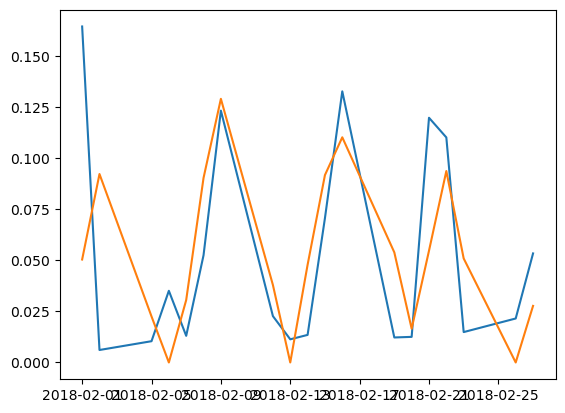

In [177]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(tru_test['date'], tru_test['True'], label="True value")
#final_predictions.plot(x='date', y='normalized_prediction')
plt.plot(final_predictions['date'],final_predictions['normalized_prediction'], label="LSTM Prediction")

In [131]:
df_submission = pd.read_parquet('submission_data.parquet')
df_submission.head()

,country,brand,dayweek,month,wd_perc,ther_area,hospital_rate,n_nwd_bef,n_nwd_aft,n_weekday_0,n_weekday_1,n_weekday_2,n_weekday_3,n_weekday_4,date,wd,wd_left,main_channel
5356,Aldovia,AIMST,0.0,1.0,0.047619,NaN,NaN,2.0,0.0,5,4,4,4,4,2022-01-03,1,20,NaN
5357,Aldovia,AIMST,1.0,1.0,0.095238,NaN,NaN,0.0,0.0,5,4,4,4,4,2022-01-04,2,19,NaN
5358,Aldovia,AIMST,2.0,1.0,0.142857,NaN,NaN,0.0,0.0,5,4,4,4,4,2022-01-05,3,18,NaN
5359,Aldovia,AIMST,3.0,1.0,0.190476,NaN,NaN,0.0,0.0,5,4,4,4,4,2022-01-06,4,17,NaN
5360,Aldovia,AIMST,4.0,1.0,0.238095,NaN,NaN,0.0,2.0,5,4,4,4,4,2022-01-07,5,16,NaN


In [132]:
df_submission_them = df_submission[(df_submission['country']=='Themyscira')]

In [129]:
df_submission_them['month'] = df_submission_them['date'].dt.to_period('M')
# Count the number of entries (days) in each month
monthly_day_count = df_submission_them.groupby('month').size()
monthly_day_count

Series([], Freq: M, dtype: int64)

In [137]:
df_submission[(df_submission['brand']=='EUJWP')]

,country,brand,dayweek,month,wd_perc,ther_area,hospital_rate,n_nwd_bef,n_nwd_aft,n_weekday_0,n_weekday_1,n_weekday_2,n_weekday_3,n_weekday_4,date,wd,wd_left,main_channel
69295,Aldovia,EUJWP,0.0,1.0,0.047619,A,0.000385,2.0,0.0,5,4,4,4,4,2022-01-03,1,20,RETAIL
69296,Aldovia,EUJWP,1.0,1.0,0.095238,A,0.000385,0.0,0.0,5,4,4,4,4,2022-01-04,2,19,RETAIL
69297,Aldovia,EUJWP,2.0,1.0,0.142857,A,0.000385,0.0,0.0,5,4,4,4,4,2022-01-05,3,18,RETAIL
69298,Aldovia,EUJWP,3.0,1.0,0.190476,A,0.000385,0.0,0.0,5,4,4,4,4,2022-01-06,4,17,RETAIL
69299,Aldovia,EUJWP,4.0,1.0,0.238095,A,0.000385,0.0,2.0,5,4,4,4,4,2022-01-07,5,16,RETAIL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66027,Zamunda,EUJWP,0.0,12.0,0.733333,A,0.000201,2.0,0.0,3,3,3,2,4,2022-12-19,11,4,RETAIL
66028,Zamunda,EUJWP,1.0,12.0,0.800000,A,0.000201,0.0,0.0,3,3,3,2,4,2022-12-20,12,3,RETAIL
66029,Zamunda,EUJWP,2.0,12.0,0.866667,A,0.000201,0.0,0.0,3,3,3,2,4,2022-12-21,13,2,RETAIL
66030,Zamunda,EUJWP,3.0,12.0,0.933333,A,0.000201,0.0,0.0,3,3,3,2,4,2022-12-22,14,1,RETAIL
